In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
## label 1 for crash 0 for non crash
train=[]
label=[]
for imgs in os.listdir('embed_crash'):
  img=cv2.imread('embed_crash/'+imgs)
  img=cv2.resize(img,(256,256))
  img=img/255.0
  train.append(img)
  label.append(1)

In [0]:
for imgs in os.listdir('embed_images'):

  img=cv2.imread('embed_images/'+imgs)
  img=cv2.resize(img,(256,256))
  img=img/255.0
  train.append(img)
  label.append(0)

In [0]:
train=np.array(train)
label=np.array(label)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
     featurewise_center=False,
     featurewise_std_normalization=False,
     rotation_range=2,
     width_shift_range=2,
     height_shift_range=2,
     brightness_range=[0.5, 1.5],
     zoom_range=[0.9, 1.5],
     shear_range=0.05,
     validation_split=0.2,
     # rescale=1/255.
    )

In [0]:
datagen.fit(train)

In [0]:
from sklearn.utils import shuffle
train,label=shuffle(train,label)

304


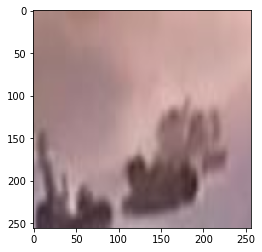

1

In [0]:
import random
r = random.randint(0, len(train)-1)
print(r)
plt.imshow(train[r])

plt.show()
label[r]

In [0]:
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras.applications.vgg16 import VGG16
import cv2
input_tensor = Input(shape=(256, 256, 3))
## VGG 16 bad accuracy
base_model = VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
for l in base_model.layers: 
    l.trainable=False

c3,p3=base_model.get_layer('block3_conv3').output,base_model.get_layer('block3_pool').output ## 96X64X64
c4,p4=base_model.get_layer('block4_conv3').output,base_model.get_layer('block4_pool').output
c5=Conv2D(32, (3, 3), padding='valid', activation='relu')(c4)
m1=MaxPool2D((2,2))(c5)
c6=Conv2D(64, (3, 3), padding='valid', activation='relu')(m1)
m2=MaxPool2D((2,2))(c6)
c7=Conv2D(128, (1, 1), padding='valid', activation='relu')(m2)
flatten_layer=Flatten()(c7)
d1=Dropout(0.2)(flatten_layer)


dense1=Dense(5000,activation='relu')(d1)
d2=Dropout(0.3)(dense1)

dense2=Dense(1024,activation='relu')(d2)
dense3=Dense(512,activation='relu')(dense2)

output=Dense(1,activation='sigmoid')(dense3)


Using TensorFlow backend.






58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(input_tensor, output)


In [0]:
model.summary()

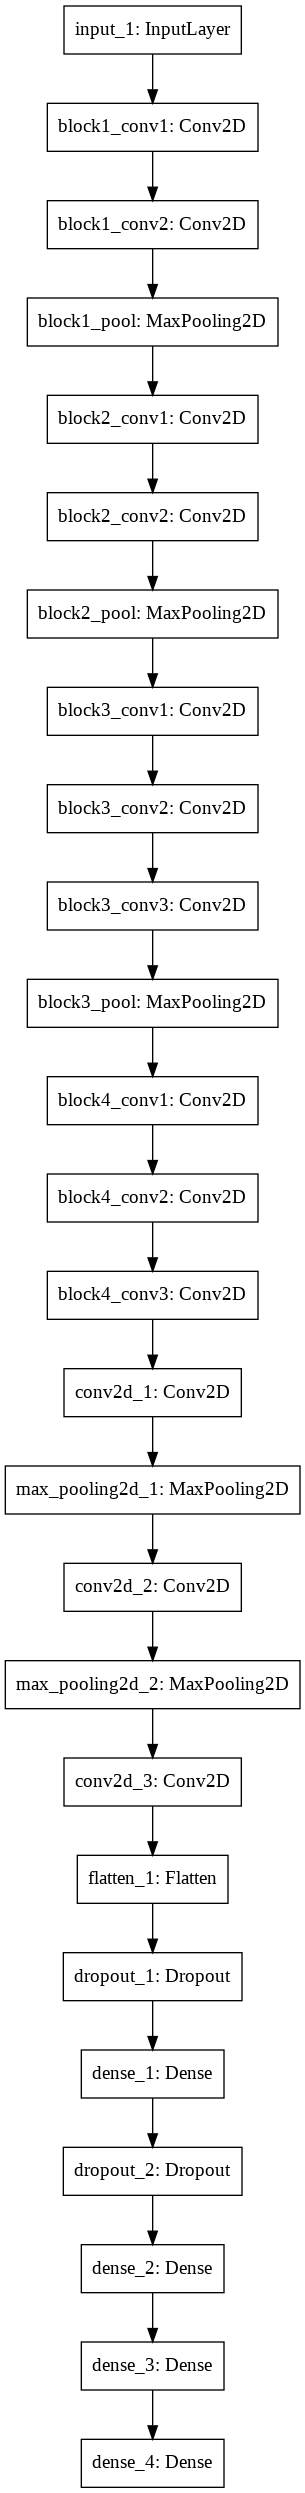

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:

opt=optimizers.Adagrad(lr=0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
model.fit_generator(datagen.flow(train, label, batch_size=5),
                    steps_per_epoch=len(train) / 5, epochs=5)

In [0]:
model.fit(train,label,batch_size=1,epochs=10,validation_split=0.2)

Train on 876 samples, validate on 219 samples
Epoch 1/10
876/876 [==============================] - 160s 182ms/step - loss: 0.3887 - acc: 0.8847 - val_loss: 3.3078 - val_acc: 0.5479
Epoch 2/10
876/876 [==============================] - 156s 178ms/step - loss: 0.2373 - acc: 0.9429 - val_loss: 0.7926 - val_acc: 0.8767
Epoch 3/10
876/876 [==============================] - 159s 181ms/step - loss: 0.1374 - acc: 0.9829 - val_loss: 0.3625 - val_acc: 0.9452
Epoch 4/10
876/876 [==============================] - 154s 176ms/step - loss: 0.0643 - acc: 0.9909 - val_loss: 2.2280 - val_acc: 0.8128
Epoch 5/10
876/876 [==============================] - 153s 175ms/step - loss: 0.0694 - acc: 0.9943 - val_loss: 3.6643 - val_acc: 0.7397
Epoch 6/10
876/876 [==============================] - 152s 173ms/step - loss: 0.0363 - acc: 0.9943 - val_loss: 0.8319 - val_acc: 0.9315
Epoch 7/10
876/876 [==============================] - 154s 176ms/step - loss: 0.0200 - acc: 0.9977 - val_loss: 1.0288 - val_acc: 0.9132
Ep

In [0]:
print(model.predict(np.expand_dims(train[1065],0))[0][0])
label[1065]

0.9958781


1

In [0]:
model.save_weights('crash.h5')

In [0]:
label_hat=[]
c=0
for imgs in train:
  print(c)
  c+=1
  if(model.predict(np.expand_dims(imgs,0))[0][0]>0.5):
    label_hat.append(1)
  else:
    label_hat.append(0)


In [0]:
ctr=0
for x,y in zip(label_hat,label):
  if(x==1*y):
    ctr+=1
ctr/len(label_hat)


0.9808219178082191

In [0]:
emb_model=Model(model.inputs,model.layers[-2].output)


In [0]:
embs=[]
ctr=0
for i in train:
  ctr+=1
  print(ctr)
  embs.append(emb_model.predict(np.expand_dims(i,0)))

In [0]:
for i in range(len(embs)):
  embs[i]=embs[i].reshape((512,))

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(embs))

In [0]:
import pickle

# Create your model here (same as above)

# Save to file in the current working directory
pkl_filename = 'pickle_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeans, file)

In [0]:
img=cv2.imread('test_car333.jpg')
img=cv2.resize(img,(256,256))
img=img/255.0
model.predict(np.expand_dims(train[671],0))[0][0]

0.0

In [0]:
predictions=kmeans.predict(np.expand_dims(embs[1012],0))
label[1012],predictions[0]

(1, 1)

In [0]:
predictions

array([1], dtype=int32)

In [0]:
ctr=0
for x,y in zip(embs,label):
  x=kmeans.predict(np.expand_dims(x,0))[0]
  if(x==y):
    ctr+=1
ctr/len(label_hat)

0.9799086757990868

In [0]:
!unzip embed_crash.zip


Archive:  embed_crash.zip
   creating: embed_crash/
  inflating: embed_crash/frame238shivam1710.jpg  
   creating: __MACOSX/
   creating: __MACOSX/embed_crash/
  inflating: __MACOSX/embed_crash/._frame238shivam1710.jpg  
  inflating: embed_crash/frame449_sanket13200.jpg  
  inflating: __MACOSX/embed_crash/._frame449_sanket13200.jpg  
  inflating: embed_crash/frame8_sanket760.jpg  
  inflating: __MACOSX/embed_crash/._frame8_sanket760.jpg  
  inflating: embed_crash/00000100sanket910.jpg  
  inflating: __MACOSX/embed_crash/._00000100sanket910.jpg  
  inflating: embed_crash/frame94shivam1100.jpg  
  inflating: __MACOSX/embed_crash/._frame94shivam1100.jpg  
  inflating: embed_crash/frame201_sanket321.jpg  
  inflating: __MACOSX/embed_crash/._frame201_sanket321.jpg  
  inflating: embed_crash/frame91manjeet71.jpg  
  inflating: __MACOSX/embed_crash/._frame91manjeet71.jpg  
  inflating: embed_crash/frame444shivam3040.jpg  
  inflating: __MACOSX/embed_crash/._frame444shivam3040.jpg  
  inflatin

In [0]:
!unzip embed_images.zip

Archive:  embed_images.zip
   creating: embed_images/
  inflating: embed_images/102nd_502621.jpg  
   creating: __MACOSX/embed_images/
  inflating: __MACOSX/embed_images/._102nd_502621.jpg  
  inflating: embed_images/102nd_492540.jpg  
  inflating: __MACOSX/embed_images/._102nd_492540.jpg  
  inflating: embed_images/102nd_514731.jpg  
  inflating: __MACOSX/embed_images/._102nd_514731.jpg  
  inflating: embed_images/102nd_20151446.jpg  
  inflating: __MACOSX/embed_images/._102nd_20151446.jpg  
  inflating: embed_images/102nd_12771345.jpg  
  inflating: __MACOSX/embed_images/._102nd_12771345.jpg  
  inflating: embed_images/102nd_480420.jpg  
  inflating: __MACOSX/embed_images/._102nd_480420.jpg  
  inflating: embed_images/102nd_506651.jpg  
  inflating: __MACOSX/embed_images/._102nd_506651.jpg  
  inflating: embed_images/102nd_471340.jpg  
  inflating: __MACOSX/embed_images/._102nd_471340.jpg  
  inflating: embed_images/102nd_529881.jpg  
  inflating: __MACOSX/embed_images/._102nd_529881